### Imports and Set Up

In [2]:
import scanpy as sc
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score 
import numpy as np
import pandas as pd
import time
import modelMLP 
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [3]:
sc.settings.verbosity
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

### Prepping Data

##### expression profile

In [ ]:
adata =  sc.read_h5ad("data/Norman_2019.h5ad")  # replace with your path

#export data from sc.read
ddata = adata.X.toarray()
labels = adata.obs['perturbation_name'].to_numpy()
parsed_labels = [p.split('+') if p != 'control' else [] for p in labels]
mlb = MultiLabelBinarizer()
labels_int = mlb.fit_transform(parsed_labels)

##### creating positional encoding

In [ ]:
import pyensembl
from tqdm import tqdm

data = pyensembl.EnsemblRelease(109)
data.download()
data.index()

In [6]:
chromosome_lengths = {
    #from https://www.ncbi.nlm.nih.gov/grc/human/data
    # Autosomes
    '1': 231223641,
    '2': 240863511,
    '3': 198255541,
    '4': 189962376,
    '5': 181358067,
    '6': 170078524,
    '7': 158970135,
    '8': 144768136,
    '9': 122084564,
    '10': 133263006,
    '11': 134634058,
    '12': 133137821,
    '13': 97983128,
    '14': 91660769,
    '15': 85089576,
    '16': 83378703,
    '17': 83481871,
    '18': 80089650,
    '19': 58440758,
    '20': 63944268,
    '21': 40088623,
    '22': 40181019,
    # Sex Chromosomes
    'X': 154893034,
    'Y': 26452288
}

chr_names = [str(i) for i in range(1, 23)] + ['X', 'Y']
chromosome_map = {name: i for i, name in enumerate(chr_names)}

In [65]:
gene_to_pos_encoding = {}
zero_encoding = np.zeros(24)

for gene_name in tqdm(adata.var_names):
    try:
        gene = data.genes_by_name(gene_name)
        encoding = np.zeros(24)
        contig = gene[0].contig
        if pd.notna(contig) and contig in chromosome_map:
            chr_index = chromosome_map[contig]
            chr_length = chromosome_lengths.get(contig, 0)
            if chr_length > 0:
                encoding[chr_index] = gene[0].start / chr_length
        gene_to_pos_encoding[gene_name] = encoding
    except (ValueError, KeyError):
        continue 



final_positional_encoding = []

for perturbation_string in tqdm(adata.obs['perturbation_name']):
    if perturbation_string == 'control':
        final_positional_encoding.append(zero_encoding)
        continue

    gene_names_in_pert = perturbation_string.split('+')
    
    encodings_for_this_cell = []
    for gene_name in gene_names_in_pert:
        encoding = gene_to_pos_encoding.get(gene_name, zero_encoding)
        encodings_for_this_cell.append(encoding)

    averaged_encoding = np.mean(encodings_for_this_cell, axis=0)
    final_positional_encoding.append(averaged_encoding)

final_positional_encoding = np.array(final_positional_encoding)

print(f"\nSUCCESS: Final matrix generated with shape {final_positional_encoding.shape}")

100%|██████████| 111255/111255 [00:00<00:00, 310936.89it/s]


SUCCESS: Final matrix generated with shape (111255, 24)


##### concatenating representations

In [68]:
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split

In [69]:
distances = adata.obsp['distances']
connectivities = adata.obsp['connectivities']


matrices_to_stack = [
    csr_matrix(ddata),
    csr_matrix(final_positional_encoding),
    csr_matrix(distances),
    csr_matrix(connectivities)
]

X_combined_sparse = hstack(matrices_to_stack)

In [70]:
X_combined_sparse.shape

(111255, 241552)

In [71]:
#split data
X_train, X_test, y_train, y_test = train_test_split(
    ddata, 
    labels_int, 
    test_size=0.2, 
    random_state=67, #SIX SEVEENNNNNNNNNN
    #stratify=labels_int
)

##### Prepping Model

In [72]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
from modelTRAN import TransMLP

input_size = X_train.shape[1] # Number of genes
num_classes = labels_int[0].size
learning_rate = 0.00026
num_epochs = 25

model = modelMLP.MLP(input_size=input_size, num_classes=num_classes)
criterion = nn.BCEWithLogitsLoss() # Best for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay= 2e-6)





In [ ]:
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import modelCROSSATTN

expression_data = adata.X
positional_data = final_positional_encoding
    
    # --- Create the full dataset object ---
full_dataset = modelCROSSATTN.PerturbationMultiModalDataset(expression_data, positional_data, labels_int)

    # --- Split indices for training and validation ---
train_indices, test_indices = train_test_split(
    range(len(full_dataset)), 
    test_size=0.2, 
    random_state=67
)
train_dataset = Subset(full_dataset, train_indices)
test_dataset = Subset(full_dataset, test_indices)

    # --- Create DataLoaders ---
batch_size = 32 # You might need to adjust this based on GPU memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # --- Define Hyperparameters and Instantiate Model ---
model = modelCROSSATTN.MultiModalCrossAttentionModel(
    n_genes=adata.n_vars,
    n_positional_features=positional_data.shape[1],
    n_classes=labels_int.shape[1],
    embed_dim=128,
    n_heads=8,
    dropout=0.2
)
    
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
num_epochs = 50
'''
    # --- Training and Evaluation Loop ---
print("\nStarting training of the Multi-Modal Cross-Attention Model...")
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for (expression, position), labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        optimizer.zero_grad()
            
            # The model's forward pass now takes two inputs
        outputs = model(expression, position)
            
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        
    avg_train_loss = total_train_loss / len(train_loader)

        # Validation
    model.eval()
    all_test_preds, all_test_labels = [], []
    total_test_loss = 0
    with torch.no_grad():
        for (expression, position), labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            outputs = model(expression, position)
            loss = criterion(outputs, labels)
            total_test_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_test_preds.append(preds.cpu().numpy())
            all_test_labels.append(labels.cpu().numpy())
        
    avg_test_loss = total_test_loss / len(test_loader)
    val_f1 = f1_score(np.vstack(all_test_labels), np.vstack(all_test_preds), average='micro')
        
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_test_loss:.4f} | Val F1: {val_f1:.4f}")
'''



Starting training of the Multi-Modal Cross-Attention Model...


Epoch 1/50 [Train]:  13%|█▎        | 351/2782 [00:03<00:21, 114.89it/s]


KeyboardInterrupt: 

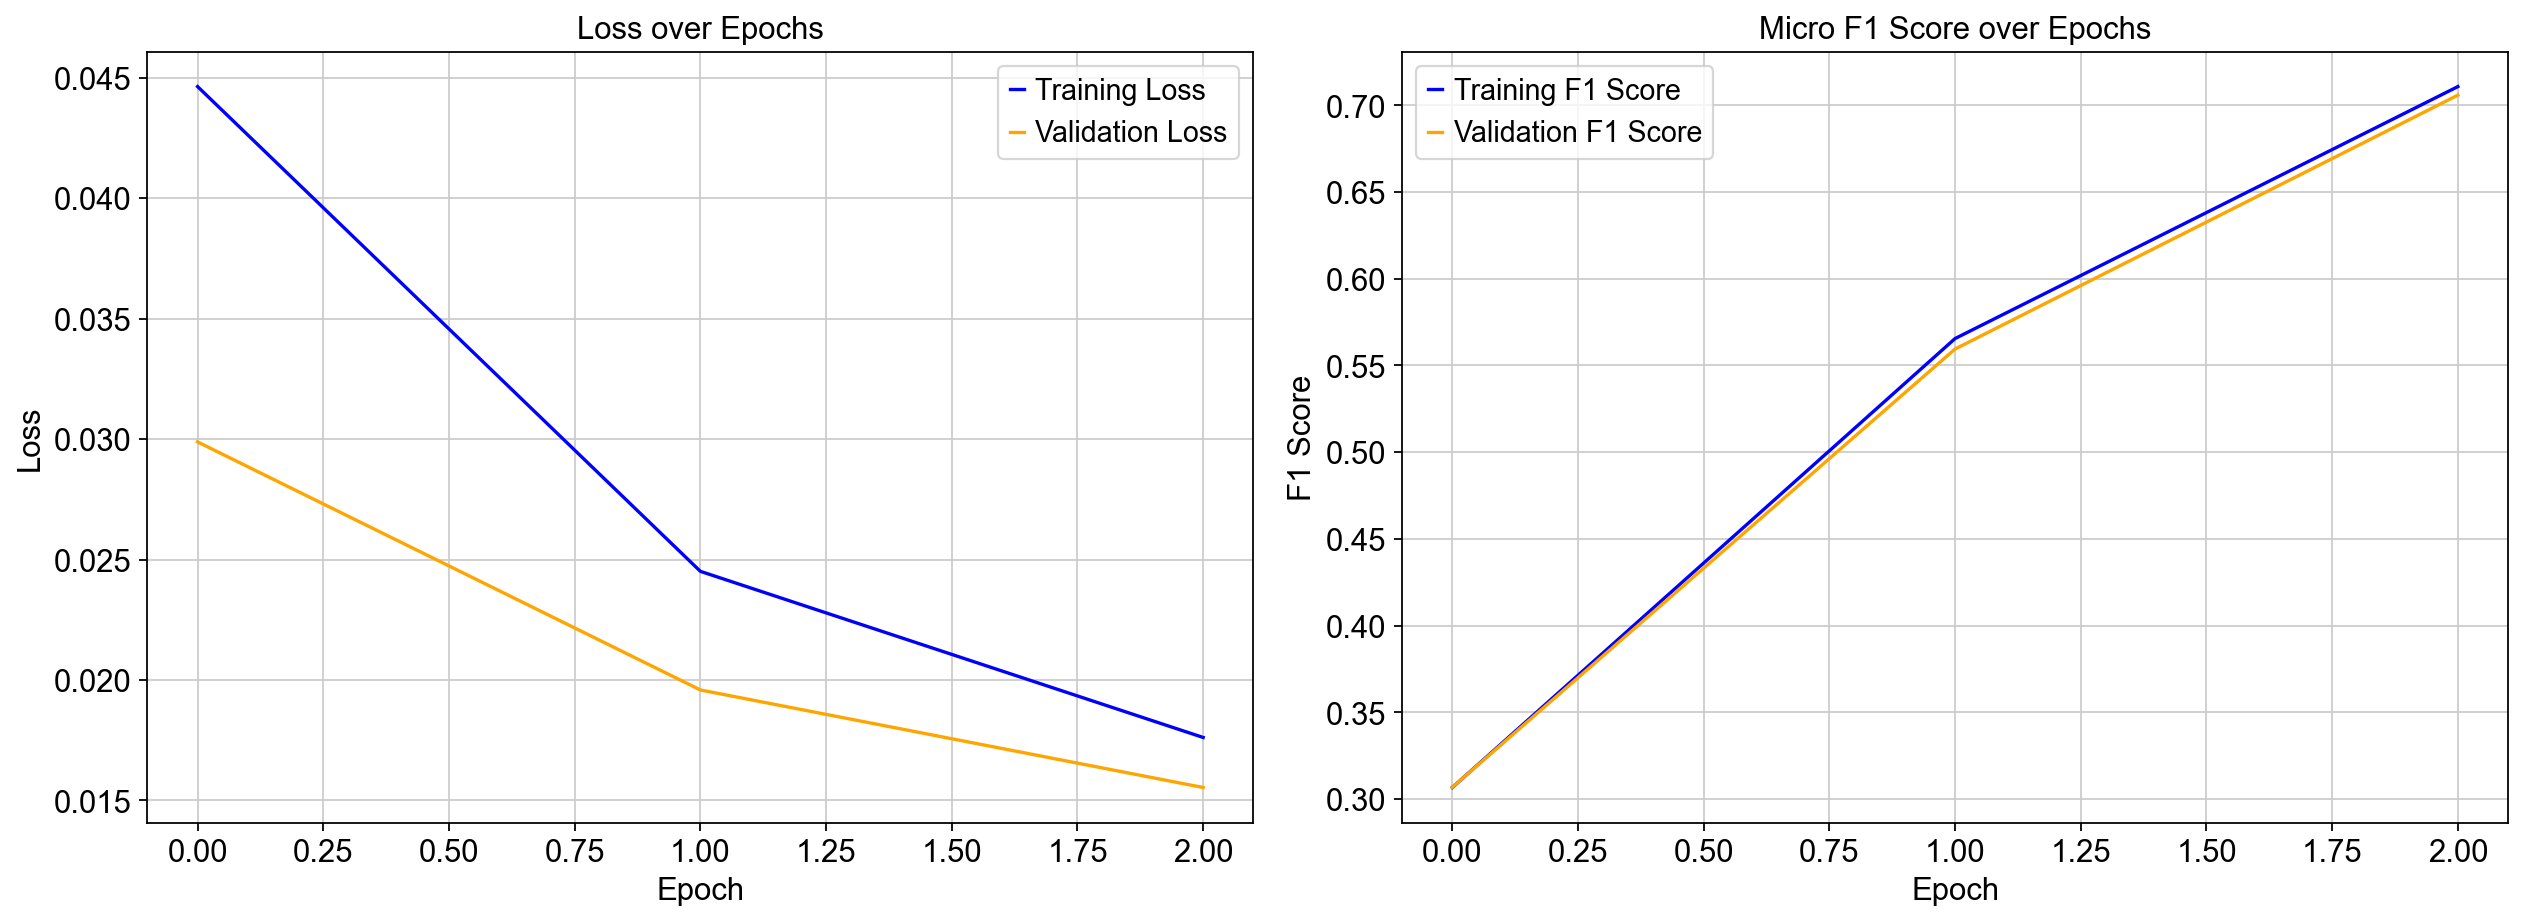

Epoch 3/50 | Train Loss: 0.0176 | Val Loss: 0.0155 | Train F1: 0.7109 | Val F1: 0.7059


Epoch 4/50 [Train]:  59%|█████▉    | 1637/2782 [00:12<00:09, 125.46it/s]

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

# --- This block assumes the following variables are already defined: ---
# model: Your instantiated PyTorch model
# train_loader: Your DataLoader for the training set
# test_loader: Your DataLoader for the validation/test set
# criterion: Your loss function (e.g., nn.BCEWithLogitsLoss())
# optimizer: Your optimizer (e.g., torch.optim.Adam(...))
# num_epochs: The total number of epochs to train for

# --- 1. Initialization for Plotting ---
# Create lists to store the history of metrics
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

# Create a figure and axes for the plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
# Initially display the empty figure
display(fig)

print("\nStarting training with live plotting...")
for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()
    total_train_loss = 0
    # Use tqdm for a progress bar on the training data
    for (expression, position), labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False):
        optimizer.zero_grad()
        
        # The model's forward pass now takes two inputs
        outputs = model(expression, position)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- Evaluation Phase ---
    model.eval()
    all_val_preds, all_val_labels = [], []
    all_train_preds, all_train_labels = [], []
    total_val_loss = 0
    
    with torch.no_grad():
        # Get validation metrics
        for (expression, position), labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False):
            outputs = model(expression, position)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_val_preds.append(preds.cpu().numpy())
            all_val_labels.append(labels.cpu().numpy())

        # Also get training metrics for comparison (important for diagnosing overfitting)
        for (expression, position), labels in train_loader:
            outputs = model(expression, position)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_train_preds.append(preds.cpu().numpy())
            all_train_labels.append(labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    train_f1 = f1_score(np.vstack(all_train_labels), np.vstack(all_train_preds), average='micro')
    val_f1 = f1_score(np.vstack(all_val_labels), np.vstack(all_val_preds), average='micro')
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)
        
    # --- 2. Live Plotting Logic ---
    # Clear the previous plot from each axis
    ax1.clear()
    ax2.clear()
    
    # Plot Loss Curves
    ax1.plot(train_losses, label='Training Loss', color='blue')
    ax1.plot(val_losses, label='Validation Loss', color='orange')
    ax1.set_title('Loss over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot F1 Score Curves
    ax2.plot(train_f1_scores, label='Training F1 Score', color='blue')
    ax2.plot(val_f1_scores, label='Validation F1 Score', color='orange')
    ax2.set_title('Micro F1 Score over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('F1 Score')
    ax2.legend()
    ax2.grid(True)
    
    fig.tight_layout()
    
    # Redraw the plot in the same cell
    clear_output(wait=True)
    display(fig)
    time.sleep(0.1) # A small pause to ensure the plot renders smoothly

    # Print a summary for the current epoch
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")

# --- 3. Cleanup after the loop is done ---
plt.close(fig)
print(f"\nTraining Complete. Final Validation F1 Score: {val_f1_scores[-1]:.4f}")